In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import networkx as nx

import math
from scipy import stats
from itertools import chain, combinations, product, compress

## Exercise #1

In [2]:
D1 = scipy.io.loadmat('data/D1.mat')["D"]
D2 = scipy.io.loadmat('data/D2.mat')["D"]
D3 = scipy.io.loadmat('data/D3.mat')["D"]
D4 = scipy.io.loadmat('data/D4.mat')["D"]

In [3]:
def create_combinations(items):
    return list(set(compress(items,mask)) for mask in product(*[[0,1]]*len(items)))

def min_d_num(G, graph_nodes):
    minimum_n = []
    for N in graph_nodes:
        neigh = list(G.neighbors(N))
        minimum_n.append(len(neigh))
    return max(minimum_n)

def ci_test(D, X, Y, Z):
    alpha = 0.06
    n = D.shape[0]
    if len(Z) == 0:
        r = np.corrcoef(D[:, [X, Y]].T)[0][1]
    else:
        sub_index = [X, Y]
        sub_index.extend(Z)
        sub_corr = np.corrcoef(D[:, sub_index].T)
        # inverse matrix
        try:
            PM = np.linalg.inv(sub_corr)
        except np.linalg.LinAlgError:
            PM = np.linalg.pinv(sub_corr)
        r = -1 * PM[0, 1] / math.sqrt(abs(PM[0, 0] * PM[1, 1]))
    cut_at = 0.99999
    r = min(cut_at, max(-1 * cut_at, r))  # make r between -1 and 1

    # Fisher’s z-transform
    res = math.sqrt(n - len(Z) - 3) * .5 * math.log1p((2 * r) / (1 - r))
    p_value = 2 * (1 - stats.norm.cdf(abs(res)))

    return p_value >= alpha

def SGS_new(matrix):
    graph_nodes = list(range(matrix.shape[1]))
    G = nx.Graph()
    G.add_nodes_from(graph_nodes)
    ci_number = 0
    extracted_Z = []
    checked_nodes = []
    
    for X in graph_nodes:
        for Y in graph_nodes:
            if X == Y: continue
            elif [X, Y] in checked_nodes: continue
            else:
                V = list(range(matrix.shape[1]))
                del V[V.index(X)]
                del V[V.index(Y)]
                
                ci_res = False

                for Z in sorted(create_combinations(V), reverse = True):
                    ci_res = ci_test(matrix, X, Y, list(Z))
                    ci_number += 1
                    checked_nodes.append([X, Y])
                    checked_nodes.append([Y, X])
                    if ci_res == True:
                        extracted_Z.append([X, Y, list(Z)])
                        break

                if ci_res == False:
                    G.add_edge(X,Y)
                    
    return nx.adjacency_matrix(G).todense(), extracted_Z, ci_number

def PC1_new(matrix):
    graph_nodes = list(range(matrix.shape[1]))
    G = nx.Graph()
    G.add_nodes_from(graph_nodes)
    ci_number = 0
    extracted_Z = []
    checked_nodes = []
    for X in graph_nodes:
        for Y in graph_nodes:
            if X == Y: continue
            else:
                G.add_edge(X,Y)

    d = 0
    while min_d_num(G, graph_nodes) >= d:
        checked_nodes2 = []
        for X in graph_nodes:
            for Y in graph_nodes:
                if X == Y:  continue
                elif [X, Y] in checked_nodes or [X, Y] in checked_nodes2: continue
                else:                  
                    V = list(range(matrix.shape[1]))
                    del V[V.index(X)]
                    del V[V.index(Y)]

                    for Z in combinations(V, d):
                        Z = list(Z)
                        ci_res = ci_test(matrix, X, Y, Z)
                        ci_number += 1
                        if ci_res == True:
                            extracted_Z.append([X, Y, Z])
                            G.remove_edge(X,Y)
                            checked_nodes.append([X, Y])
                            checked_nodes.append([Y, X])
                            break
                        else:
                            checked_nodes2.append([X, Y])
                            checked_nodes2.append([Y, X])                 
            
        d += 1
    return nx.adjacency_matrix(G).todense(), extracted_Z, ci_number

def PC2_new(matrix):
    graph_nodes = list(range(matrix.shape[1]))
    G = nx.Graph()
    G.add_nodes_from(graph_nodes)
    ci_number = 0
    extracted_Z = []
    checked_nodes = []
    checked_nodes2 = []

    d = 0
    for X in graph_nodes:
        for Y in graph_nodes:
            if X == Y: continue
            elif [X, Y] in checked_nodes: continue
            else:
                V = list(range(matrix.shape[1]))
                del V[V.index(X)]
                del V[V.index(Y)]

                if ci_test(matrix, X, Y, V) == False:
                    ci_number += 1
                    G.add_edge(X,Y)
                    checked_nodes.append([X, Y])
                    checked_nodes.append([Y, X])
    
    while min_d_num(G, graph_nodes) >= d:
        checked_nodes3 = []
        for X in graph_nodes:
            for Y in graph_nodes:
                if X == Y: continue
                elif [X, Y] in checked_nodes2 or [X, Y] in checked_nodes3: continue
                elif G.has_edge(X,Y) == False: continue
                else:
                    V = list(range(matrix.shape[1]))
                    del V[V.index(X)]
                    del V[V.index(Y)]

                    for Z in combinations(V, d):
                        Z = list(Z)
                        ci_res = ci_test(matrix, X, Y, Z)
                        ci_number += 1
                        if ci_res == True:
                            extracted_Z.append([X, Y, Z])
                            checked_nodes2.append([X,Y])
                            checked_nodes2.append([Y,X])
                            G.remove_edge(X,Y)
                            break

                        else:
                            checked_nodes3.append([X, Y])
                            checked_nodes3.append([Y, X])
        d += 1
    return nx.adjacency_matrix(G).todense(), extracted_Z, ci_number

def retrieve_v_shape(MM, cond_sub):
    GG = nx.from_numpy_matrix(MM, create_using= nx.DiGraph())
    for X in range(len(MM)):
        for Y in range(len(MM)):
            if X == Y: continue
            for W in range(len(MM)):
                # Avoid to consider the same node
                if W == Y or W == X: continue
                else:
                    # Check the link between X ans Y
                    XY_link = GG.has_edge(X,Y)
                    # Check the link between Y ans W
                    YW_link = GG.has_edge(Y,W)
                    # Check the link between W ans X
                    WX_link = GG.has_edge(W,X)
                    if XY_link == True and YW_link == True and WX_link == False:
                        checker = []
                        for i in cond_sub:
                            if X == i[0] and W == i[1] and Y not in i[2]:
                                # Z does not includes Y
                                checker.append(True)
                            elif X == i[0] and W == i[1] and Y in i[2]:
                                # Z includes Y
                                checker.append(False)
                                break
                        test = all(p == True for p in checker)

                        if test is True and len(checker) > 0:
                            # Remove the link Y --> X
                            try:
                                GG.remove_edge(Y, X)
                            except nx.NetworkXError:
                                None
                            # Remove the link Y --> W
                            try:
                                GG.remove_edge(Y, W) 
                            except nx.NetworkXError:
                                None

    return nx.adjacency_matrix(GG).todense()

def rulmk1 (MM):
    GG = nx.from_numpy_matrix(MM, create_using= nx.DiGraph())
    for A in range(len(MM)):
        for B in range(len(MM)):
            # Avoid to consider the same node
            if A == B: continue
            else:
                # Check if there is the link A --> B
                check_1 = GG.has_edge(A,B)
                # Check if there is the link B --> A
                check_2 = GG.has_edge(B,A)
                if check_1 == True and check_2 == False:
                    for C in range(len(MM)):
                        # Avoid to consider the same node
                        if C == A or C == B: continue
                        else:
                            # Check if there is the link B --> C
                            check_3 = GG.has_edge(B,C)
                            # Check if there is the link C --> B
                            check_4 = GG.has_edge(C,B)
                            # Check if there is the link A --> C
                            check_5 = GG.has_edge(A,C)
                            # Check if there is the link C --> A
                            check_6 = GG.has_edge(C,A)
                            
                            # Check if there are all the conditions for Meek Rule #2
                            if check_3 == True and check_4 == True and check_5 == False and check_6 == False:
                                # Remove the link C --> B
                                GG.remove_edge(C,B)

    return nx.adjacency_matrix(GG).todense()

def rulmk2 (MM):
    GG = nx.from_numpy_matrix(MM, create_using= nx.DiGraph())
    for A in range(len(MM)):
        for B in range(len(MM)):
            # Avoid to consider the same node
            if A == B: continue
            else:
                # Check if there is the link A --> B
                check_1 = GG.has_edge(A,B)
                # Check if there is the link B --> A
                check_2 = GG.has_edge(B,A)
                # If there is only the link A --> B
                if check_1 == True and check_2 == False:
                    for C in range(len(MM)):
                        # Avoid to consider the same node
                        if C == A or C == B: continue
                        else:
                            # Check if there is the link B --> C
                            check_3 = GG.has_edge(B,C)
                            # Check if there is the link C --> B
                            check_4 = GG.has_edge(C,B)
                            # Check if there is the link A --> C
                            check_5 = GG.has_edge(A,C)
                            # Check if there is the link C --> A
                            check_6 = GG.has_edge(C,A)

                            # Check if there are all the conditions for Meek Rule #2
                            if check_3 == True and check_4 == False and check_5 == True and check_6 == True:
                                # Remove the link C --> A
                                GG.remove_edge(C,A)
    return nx.adjacency_matrix(GG).todense()

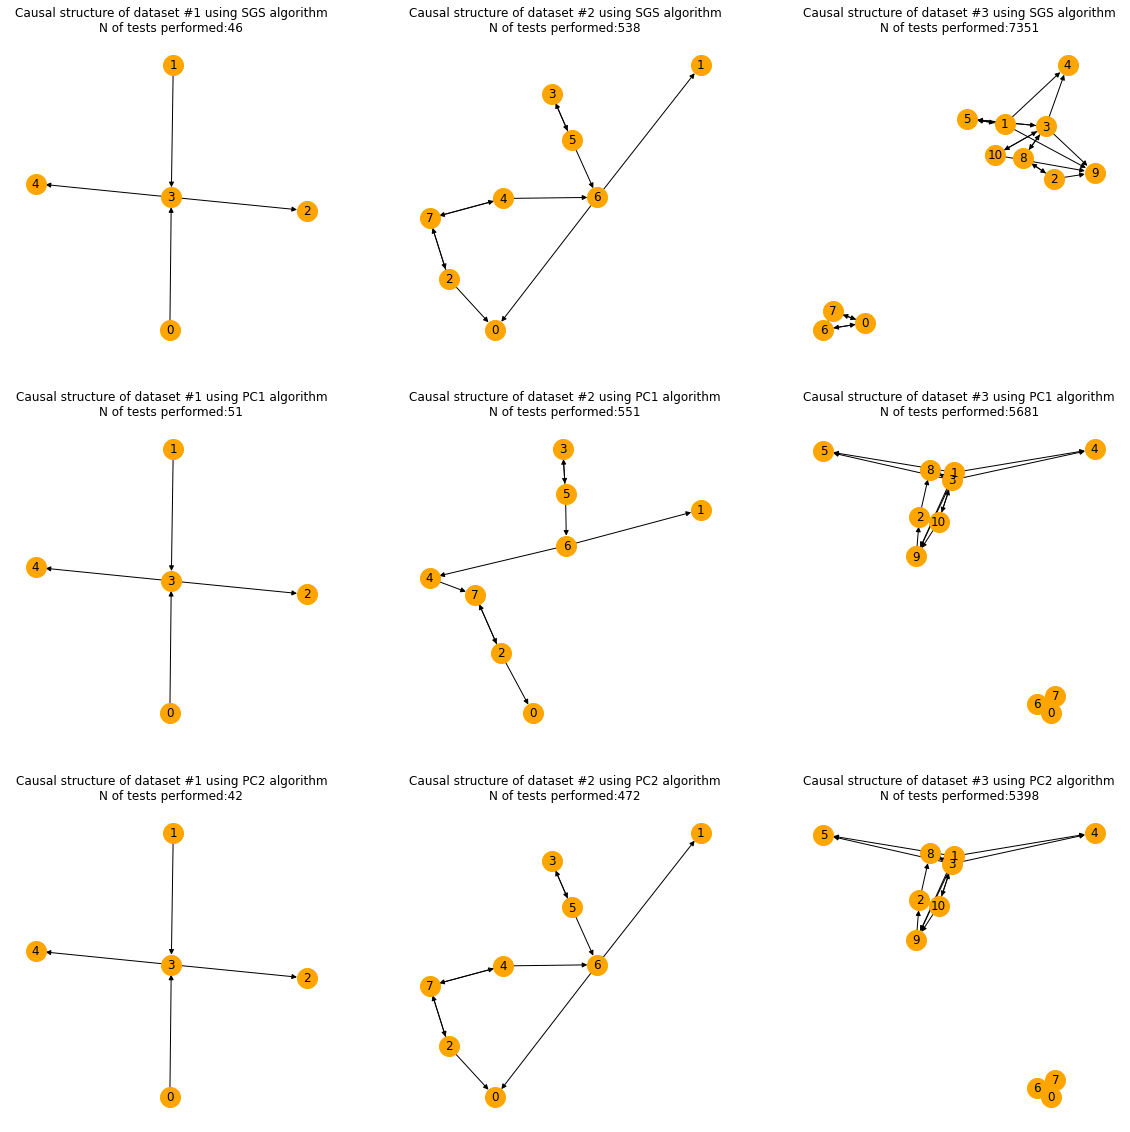

In [4]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(20,20))
ax = axes.flatten()

## Database #1 - SGS algorithm
SGS_M1, SGS_M1_Z, SGS_M1_t  = SGS_new(D1)
SGS_M1 = rulmk2(rulmk1(retrieve_v_shape(SGS_M1, SGS_M1_Z)))
SGS_G1 = nx.from_numpy_matrix(SGS_M1, create_using = nx.DiGraph())
nx.draw_networkx(SGS_G1, pos= nx.spring_layout(SGS_G1, seed = 2) , ax=ax[0], with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=12)
ax[0].set_axis_off()
title_SGS_M1 = "Causal structure of dataset #1 using SGS algorithm\n" + "N of tests performed:" + str(SGS_M1_t)
ax[0].set_title(title_SGS_M1)

## Database #2 - SGS algorithm
SGS_M2, SGS_M2_Z, SGS_M2_t = SGS_new(D2)
SGS_M2 = rulmk2(rulmk1(retrieve_v_shape(SGS_M2, SGS_M2_Z)))
SGS_G2 = nx.from_numpy_matrix(SGS_M2, create_using = nx.DiGraph())
nx.draw_networkx(SGS_G2, pos= nx.spring_layout(SGS_G2, seed = 2) , ax=ax[1], with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=12)
ax[1].set_axis_off()
title_SGS_G2 = "Causal structure of dataset #2 using SGS algorithm\n" + "N of tests performed:" + str(SGS_M2_t)
ax[1].set_title(title_SGS_G2)

## Database #3 - SGS algorithm
SGS_M3, SGS_M3_Z, SGS_M3_t = SGS_new(D3)
SGS_M3 = rulmk2(rulmk1(retrieve_v_shape(SGS_M3, SGS_M3_Z)))
SGS_G3 = nx.from_numpy_matrix(SGS_M3, create_using = nx.DiGraph())
nx.draw_networkx(SGS_G3, pos= nx.spring_layout(SGS_G3, seed = 28) , ax=ax[2], with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=12)
ax[2].set_axis_off()
title_SGS_G3 = "Causal structure of dataset #3 using SGS algorithm\n" + "N of tests performed:" + str(SGS_M3_t)
ax[2].set_title(title_SGS_G3)

## Database #1 - PC1 algorithm
PC1_M1, PC1_M1_Z, PC1_M1_t = PC1_new(D1)
PC1_M1 = rulmk2(rulmk1(retrieve_v_shape(PC1_M1, PC1_M1_Z)))
PC1_G1 = nx.from_numpy_matrix(PC1_M1, create_using = nx.DiGraph())
nx.draw_networkx(PC1_G1, pos= nx.spring_layout(PC1_G1, seed = 2) , ax=ax[3], with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=12)
ax[3].set_axis_off()
title_PC1_G1 = "Causal structure of dataset #1 using PC1 algorithm\n" + "N of tests performed:" + str(PC1_M1_t)
ax[3].set_title(title_PC1_G1)

## Database #2 - PC1 algorithm
PC1_M2, PC1_M2_Z, PC1_M2_t = PC1_new(D2)
PC1_M2 = rulmk2(rulmk1(retrieve_v_shape(PC1_M2, PC1_M2_Z)))
PC1_G2 = nx.from_numpy_matrix(PC1_M2, create_using = nx.DiGraph())
nx.draw_networkx(PC1_G2, pos= nx.spring_layout(PC1_G2, seed = 2) , ax=ax[4], with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=12)
ax[4].set_axis_off()
title_PC1_G1 = "Causal structure of dataset #2 using PC1 algorithm\n" + "N of tests performed:" + str(PC1_M2_t)
ax[4].set_title(title_PC1_G1)

## Database #3 - PC1 algorithm
PC1_M3, PC1_M3_Z, PC1_M3_t = PC1_new(D3)
PC1_M3 = rulmk2(rulmk1(retrieve_v_shape(PC1_M3, PC1_M3_Z)))
PC1_G3 = nx.from_numpy_matrix(PC1_M3, create_using = nx.DiGraph())
nx.draw_networkx(PC1_G3, pos= nx.spring_layout(PC1_G3, seed = 28) , ax=ax[5], with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=12)
ax[5].set_axis_off()
title_PC1_G3 = "Causal structure of dataset #3 using PC1 algorithm\n" + "N of tests performed:" + str(PC1_M3_t)
ax[5].set_title(title_PC1_G3)

## Database #1 - PC2 algorithm
PC2_M1, PC2_M1_Z, PC2_M1_t = PC2_new(D1)
PC2_M1 = rulmk2(rulmk1(retrieve_v_shape(PC2_M1, PC2_M1_Z)))
PC2_G1 = nx.from_numpy_matrix(PC2_M1, create_using = nx.DiGraph())
nx.draw_networkx(PC2_G1, pos= nx.spring_layout(PC2_G1, seed = 2) , ax=ax[6], with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=12)
ax[6].set_axis_off()
title_PC2_G1 = "Causal structure of dataset #1 using PC2 algorithm\n" + "N of tests performed:" + str(PC2_M1_t)
ax[6].set_title(title_PC2_G1)

## Database #2 - PC2 algorithm
PC2_M2, PC2_M2_Z, PC2_M2_t = PC2_new(D2)
PC2_M2 = rulmk2(rulmk1(retrieve_v_shape(PC2_M2, PC2_M2_Z)))
PC2_G2 = nx.from_numpy_matrix(PC2_M2, create_using = nx.DiGraph())
nx.draw_networkx(PC2_G2, pos= nx.spring_layout(PC2_G2, seed = 2) , ax=ax[7], with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=12)
ax[7].set_axis_off()
title_PC2_G2 = "Causal structure of dataset #2 using PC2 algorithm\n" + "N of tests performed:" + str(PC2_M2_t)
ax[7].set_title(title_PC2_G2)

## Database #3 - PC2 algorithm
PC2_M3, PC2_M3_Z, PC2_M3_t = PC2_new(D3)
PC2_M3 = rulmk2(rulmk1(retrieve_v_shape(PC2_M3, PC2_M3_Z)))
PC2_G3 = nx.from_numpy_matrix(PC2_M3, create_using = nx.DiGraph())
nx.draw_networkx(PC2_G3, pos= nx.spring_layout(PC2_G3, seed = 28) , ax=ax[8], with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=12)
ax[8].set_axis_off()
title_PC2_G3 = "Causal structure of dataset #3 using PC2 algorithm\n" + "N of tests performed:" + str(PC2_M3_t)
ax[8].set_title(title_PC2_G3)                
                
plt.show()

<H2 style = "color: red">IMPORTANT DISCLAIMER:</H2> One should note that bi-directional arrows used in all the graphs are NOT an indication of node directions: in our code, they are used to plot un-directed edges.

# Plots

### Database 1 - SGS

In [5]:
#Set of separating sets for non-adjacent pairs of variables
graph_nodes = list(range(D1.shape[1]))
G = nx.Graph()
G.add_nodes_from(graph_nodes)
ci_number = 0
extracted_Z = []
checked_nodes = []
    
for X in graph_nodes:
    for Y in graph_nodes:
        if X == Y: continue
        elif [X, Y] in checked_nodes: continue
        else:
            V = list(range(D1.shape[1]))
            del V[V.index(X)]
            del V[V.index(Y)]

            ci_res = False

            for Z in sorted(create_combinations(V), reverse = True):
                ci_res = ci_test(D1, X, Y, list(Z))
                ci_number += 1
                checked_nodes.append([X, Y])
                checked_nodes.append([Y, X])
                if ci_res == True:
                    extracted_Z.append([X, Y, list(Z)])
                    print("Variables:", X, Y)
                    print("Conditional set:", list(Z))
                    break

            if ci_res == False:
                G.add_edge(X,Y)

Variables: 0 1
Conditional set: []
Variables: 0 2
Conditional set: [1, 3, 4]
Variables: 0 4
Conditional set: [1, 2, 3]
Variables: 1 2
Conditional set: [3, 4]
Variables: 1 4
Conditional set: [0, 2, 3]
Variables: 2 4
Conditional set: [0, 1, 3]


### Database 4 - PC2

In [6]:
## Database #$ - PC2 algorithm
PC2_M4, PC2_M4_Z, PC2_M4_t = PC2_new(D4)
PC2_M4 = rulmk2(rulmk1(retrieve_v_shape(PC2_M4, PC2_M4_Z)))
PC2_G4 = nx.from_numpy_matrix(PC2_M4, create_using = nx.DiGraph())
title_PC2_G4 = "Causal structure of dataset #4 using PC2 algorithm\n" + "N of tests performed:" + str(PC2_M4_t)

Causal structure of dataset #4 using PC2 algorithm
N of tests performed:49698


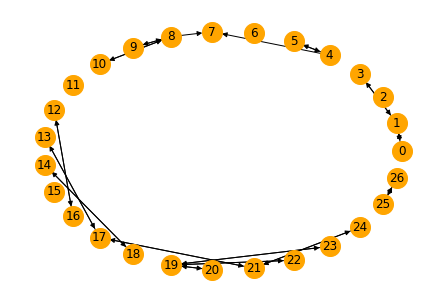

In [7]:
print(title_PC2_G4)
nx.draw_circular(PC2_G4,  with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=12)              
plt.show()

In [8]:
PC2_M4_export = np.matrix(PC2_M4)
np.savetxt('PC2_G4.csv',PC2_M4_export, delimiter=',', fmt='%10f')

## Exercise #2

In [9]:
def compute_YZ1(X, Y, Z, N, t): 
    # Fill the columns of YZ1 with certain values contained in the different nodes
    YZ1 = np.zeros((N, t + 10*(t - 1)) )
    YZ1[:, :t] = Y[:, :t] 
    for i in range(10):
        YZ1[:, t + i * (t - 1): t + (i+1) * (t - 1)] = Z[i][:, :(t - 1)]

    return YZ1.T
     
def compute_XYZ1(X, Y, Z, N, t): 
    # Fill the columns of XYZ1 with certain values contained in the different nodes
    XYZ1 = np.zeros((N, 12 * (t - 1)))
    XYZ1[:, :(t - 1)] = X[:, :(t - 1)] 
    XYZ1[:, (t - 1):(2 * (t - 1))] = Y[:, :(t - 1)]
    for i in range(10):
        XYZ1[:, ((i+2) * (t - 1)): (i+3) * (t - 1)] = Z[i][:, :(t - 1)]

    return XYZ1.T
    
def compute_YZ2(X, Y, Z, N, t): 
    # Fill the columns of YZ2 with certain values contained in the different nodes
    YZ2 = np.zeros((N, 11 * (t - 1))) 
    YZ2[:, :(t - 1)] = Y[:, :(t - 1)] 
    for i in range(10):
        YZ2[:, ((i+1) * (t - 1)): (i+2) * (t - 1)] = Z[i][:, :(t - 1)]

    return YZ2.T
    

def compute_XYZ2(X, Y, Z, N, t): 
    # Fill the columns of XYZ2 with certain values contained in the different nodes
    XYZ2 = np.zeros((N, t + 11 * (t - 1)))
    XYZ2[:, :(t - 1)] = X[:, :(t - 1)] 
    XYZ2[:, (t - 1):(2*t - 1)] = Y[:, :t]
    for i in range(10):
        XYZ2[:, t + (i+1) * (t - 1): t + (i+2) * (t - 1)] = Z[i][:, :(t - 1)]

    return XYZ2.T

def find_link(i, j, df_market, threshold):
    '''
    Calculate the DI of:
    - i --> First company taken into account 
    - j --> Second company taken into account 
    with respect to the other nodes
    '''
    X = df_market[i]
    Y = df_market[j]
    Z = np.zeros((10, 190, 7))
    N,T = np.shape(X)
    c = 0
    DI = 0
    
    # Compute the concatenation of the other nodes in order to get Z
    for k in range(n):
        if k != i and k != j:
            Z[c] = df_market[k]
            c += 1

    for t in range(2, T + 1):
        # Compute YZ1 
        YZ1 = compute_YZ1(X, Y, Z, N, t)
        # Compute XYZ1
        XYZ1 = compute_XYZ1(X, Y, Z, N, t)
        # Compute YZ2
        YZ2 = compute_YZ2(X, Y, Z, N, t)
        # Compute XYZ2
        XYZ2 = compute_XYZ2(X, Y, Z, N, t)
        
        #Put everything together
        DI = DI + 1/2 * np.log(np.linalg.det(np.cov(YZ1))/np.linalg.det(np.cov(YZ2)) * np.linalg.det(np.cov(XYZ1)) / (np.linalg.det(np.cov(XYZ2))))
    
    # Check if DI is positive or negative 
    if DI < threshold:
        return False, DI
    return True, DI 
        
def n_size_edges(nodes,edges):
    size = np.zeros(len(nodes))
    for n in nodes:
        for k in edges:
            if n in k:
                size[n] = size[n]+1      
    return size

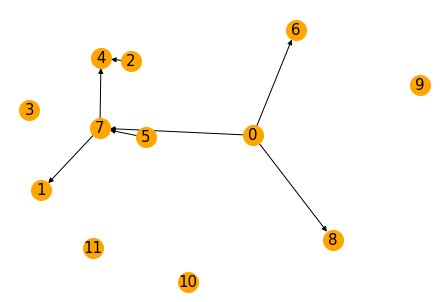

In [10]:
# Load the data
df_market = scipy.io.loadmat('data/market.mat')['DI'].T
n = len(df_market)
# Initialize the nodes and the edges (which are unknown = empty in the beginning)
node = np.arange(n) 
edges = []

DI_matrix1 = []
# For each node we check if there is a link with any other node
for i in range(n):
    DI_row = []
    for j in range(n):
        if i != j:
            
            # If a link is found, we add it as an edge between i and j
            link_bool, link_value = find_link(i, j, df_market, 0.5)
            DI_row.append(link_value)
            if link_bool == True: 
                edges.append([i, j])
        if i == j:
            DI_row.append(0)
    DI_matrix1.append(DI_row)
                
size = n_size_edges(node, edges)

G2_1 =  nx.DiGraph()
for index in range(len(node)):
        G2_1.add_node(node[index], nodesize = size[index])
for index in edges:
    G2_1.add_edge(index[0], index[1])

# Plot the graph
my_pos = nx.spring_layout(G2_1, seed = 37)
nx.draw(G2_1, pos = my_pos, with_labels =True, node_color ='orange', node_size =400, edge_color='black', linewidths =1, font_size =15)
plt.show()

In [11]:
EX2_M1 = nx.to_numpy_matrix(G2_1)
print(EX2_M1)

[[0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [12]:
DI_matrix1 = np.matrix(DI_matrix1)
np.savetxt('DI_matrix1.csv',DI_matrix1, delimiter=',', fmt='%10f')

In [13]:
def compute_tree(df_market, threshold):
    n = len(df_market)
    # Initialize the nodes and the edges (which are unknown = empty in the beginning)
    node = [] 
    edges = []
    DI_matrix2 = []
    # For each node we check if there is a link with any other node
    for i in range(n): 
        DI_row = []
        for j in range(n):
            if i != j:
                # If a link is found, we add it as an edge between i and j.
                link_bool, link_value = find_link(i, j, df_market, threshold)
                DI_row.append(link_value)
                if link_bool == True: 
                    edges.append([i, j])
                    # If a node is not already discover it is now 
                    if i not in node:   
                        node.append(i)
                    if j not in node:
                        node.append(j)
            if i == j:
                DI_row.append(0)
        DI_matrix2.append(DI_row)
                
    return node, edges, DI_matrix2



def find_ground(threshold_max, threshold_min, iterations, df_market):
    # To be sure to link the 12 nodes
    for n in range(iterations):
        
        
        threshold_new = (threshold_max + threshold_min)/2
        
        node,_,DI_matrix2  = compute_tree(df_market, threshold_new)
        
        # If all the nodes are linked together
        if len(node) == 12:
            threshold_min = threshold_new
        # If at least one node is not linked with all the other nodes
        elif len(node) < 12:
            threshold_max = threshold_new            
    return threshold_min, DI_matrix2 

In [14]:
threshold_max = 0.75
threshold_min = 0.25
iterations = 100
final_threshold, DI_matrix2 = find_ground(threshold_max, threshold_min, iterations, df_market)
print("A feasible threshold is", final_threshold)

A feasible threshold is 0.38153419677443867


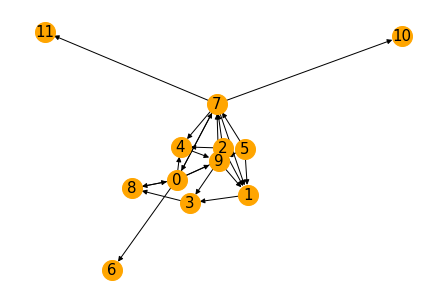

In [15]:
node, edges, DI_matrix2 = compute_tree(df_market, final_threshold)
size = n_size_edges(node, edges)
G2_2 =  nx.DiGraph()
for index in range(len(node)):
        G2_2.add_node(node[index], nodesize = size[index])
for index in edges:
    G2_2.add_edge(index[0], index[1])
    
# Plot the graph
my_pos = nx.spring_layout(G2_2, seed = 1)
nx.draw(G2_2, pos = my_pos, with_labels =True, node_color ='orange', node_size =400, edge_color='black', linewidths =1, font_size =15, k=0.15, iterations=20)
plt.show()

In [16]:
EX2_M2 = nx.adjacency_matrix(G2_2)
print(EX2_M2.todense())

[[0 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 1 0 0 1 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 1 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
